In [1]:
# Date -- 2022.Aug.28
# Using Python 3.9
'''
pip install --upgrade pip
pip install scipy
pip install jupyter matplotlib h5py
pip install emcee corner tqdm
pip install pandas
'''

'\npip install --upgrade pip\npip install scipy\npip install jupyter matplotlib h5py\npip install emcee corner tqdm\npip install pandas\n'

In [2]:
import os, sys, time

sys.path

import numpy as np

import matplotlib
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import emcee, corner
from multiprocessing import Pool
from multiprocessing import cpu_count

import pandas as pd
%matplotlib inline

from profilefit import *

#### Data explanation

In the data files, from first to last column: 

  1) offset in arcsec**, 
  
  2) intensity in Jy/beam, 
  
  3) error or stand dev* (same unit as intensity), 
  
  4) beam major axis (arcsec), 
  
  5) beam minor axis (arcsec).

# Define model function

In [3]:
def powerlaw(x, parms):
    '''
    create a power-law that is A0 * ( (r/r0)**index )
        
    Input:
        x [1d np array] : offset
        parms [list of float]  : [A0, r0, pindex]
                                 0th element: value at the specific x-variable r0
                                 1th element: the reference x-variable r0
                                 2nd element: power-law index
                                 
        A0      [float] : the value of the power law at the location r=r0
        r0      [float] : a reference location.
        pindex   [float] : power-law index
        
    Return:
        [1d np array] : A 1-dim power-law that has the same size as the x array.
    '''
    A0     = parms[0]
    r0     = parms[1]
    pindex = parms[2]
    model = A0 * ( (np.absolute(x) / r0 )**pindex )

    # Set an upper limit of dust temperature to 1500 K
    index = np.where( np.isfinite(model) == False )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
    index = np.where( model > 1500.0 )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
        
    return model
    
    
def powerlaw_lnprior(parms):
    '''
    Prior function.
    '''
    if parms[1] < 0:
        return -np.inf
    
    return 0


def brokenpowerlaw(x, parms):
    '''
    create a broken power-law
        
    Input:
        x [1d np array] : offset
        parms [list of float]  : [A0, r0, pindex1, pindex2]
                                 0th element: value at the specific x-variable r0
                                 1th element: the reference x-variable r0
                                 2nd element: power-law index at small x
                                 3rd element: power-law index at large x
                                 
        A0        [float] : the value of the power law at the location r=r0
        r0        [float] : a reference location.
        pindex1   [float] : power-law index at small x
        pindex2   [float] : power-law index at large x
        
    Return:
        [1d np array] : A 1-dim power-law that has the same size as the x array.
    '''
    A0      = parms[0]
    r0      = parms[1]
    pindex1 = parms[2]
    pindex2 = parms[3]
    
    model = np.zeros( len(x) )
    index = np.array( 
                     np.where(
                              np.absolute(x) <= r0
                             ) 
                    )
    model[index] = A0 * ( (np.absolute(x[index]) / r0 )**pindex1 )
    
    index = np.array( 
                     np.where(
                              np.absolute(x) > r0
                             ) 
                    )
    model[index] = A0 * ( (np.absolute(x[index]) / r0 )**pindex2 )

    # Set an upper limit of dust temperature to 1500 K
    index = np.where( np.isfinite(model) == False )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
    index = np.where( model > 1500.0 )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
        
    return model
    
    
def brokenpowerlaw_lnprior(parms):
    '''
    Prior function.
    '''
    if parms[1] < 0:
        return -np.inf
    
    return 0


def tripowerlaw(x, parms):
    '''
    create a broken power-law that is a combination of three power-laws.
        
    Input:
        x [1d np array] : offset
        parms [list of float]  : [A0, r0, r1, pindex1, pindex2, pindex3]
                                 0th element: value at the specific x-variable r0
                                 1th element: the reference x-variable r0
                                 2th element: the reference x-variable r1
                                 3nd element: power-law index at small x
                                 4rd element: power-law index at intermediate x
                                 5rd element: power-law index at large x
                                 
        A0        [float] : the value of the power law at the location r=r0
        r0        [float] : a reference location.
        r1        [float] : a reference location.
        pindex1   [float] : power-law index at small x
        pindex2   [float] : power-law index at large x
        pindex3   [float] : power-law index at large x
        
    Return:
        [1d np array] : A 1-dim power-law that has the same size as the x array.
    '''
    
    A0      = parms[0]
    r0      = parms[1]
    r1      = parms[2]
    pindex1 = parms[3]
    pindex2 = parms[4]
    pindex3 = parms[5]
    
    model = np.zeros( len(x) )
    index = np.array( 
                     np.where(
                              np.absolute(x) <= r0
                             ) 
                    )
    model[index] = A0 * ( (np.absolute(x[index]) / r0 )**pindex1 )
    
    index = np.array( 
                     np.where(
                               (np.absolute(x) > r0) &
                               (np.absolute(x) < r1) 
                             ) 
                    )
    model[index] = A0 * ( (np.absolute(x[index]) / r0 )**pindex2 )
    
    index = np.array( 
                     np.where(
                              np.absolute(x) > r1
                             ) 
                    )
    model[index] = A0 * ( (np.absolute(x[index]) / r0 )**pindex3 )

    # Set an upper limit of dust temperature to 1500 K
    index = np.where( np.isfinite(model) == False )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
    index = np.where( model > 1500.0 )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
        
    return model
    
    
def tripowerlaw_lnprior(parms):
    '''
    Prior function.
    '''
    if parms[1] < 0:
        return -np.inf
    
    if parms[1] > parms[2]:
        return -np.inf
    
    return 0

######## Processing ../../cuts_profiles/IRS63_b6_pa147.91_major.txt##########
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
You have 8 CPUs
########### Starting running MCMC ########### Sun Aug 28 20:06:41 2022


100%|███████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.77it/s]


########### Finished running MCMC ########### Sun Aug 28 20:06:45 2022
parameter 0: 24+2.9-11
parameter 1: 0.15+0.93-0.027
parameter 2: -0.56+0.032-0.0035


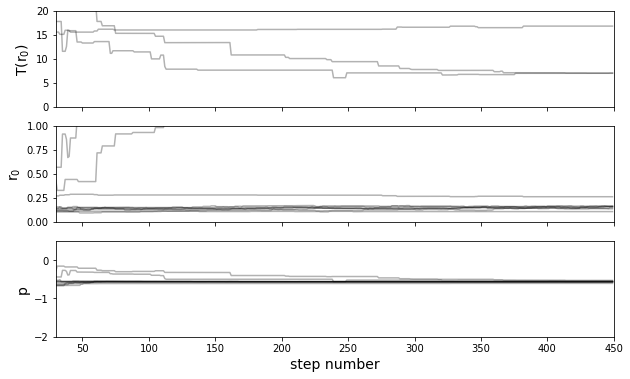

<Figure size 432x288 with 0 Axes>

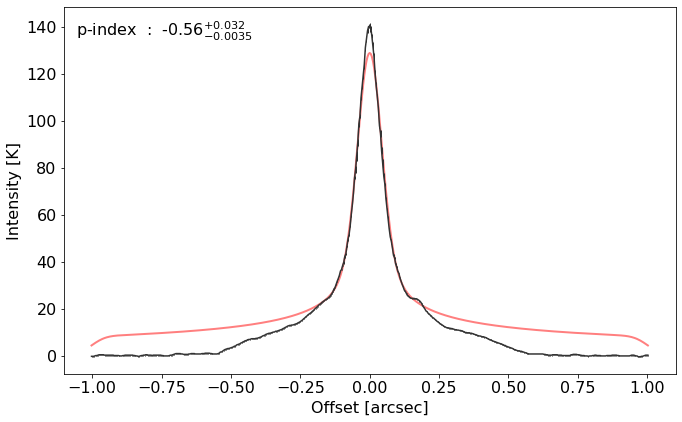

Start making corner plotSun Aug 28 20:06:46 2022


Finished making corner plotSun Aug 28 20:06:46 2022


<Figure size 432x288 with 0 Axes>

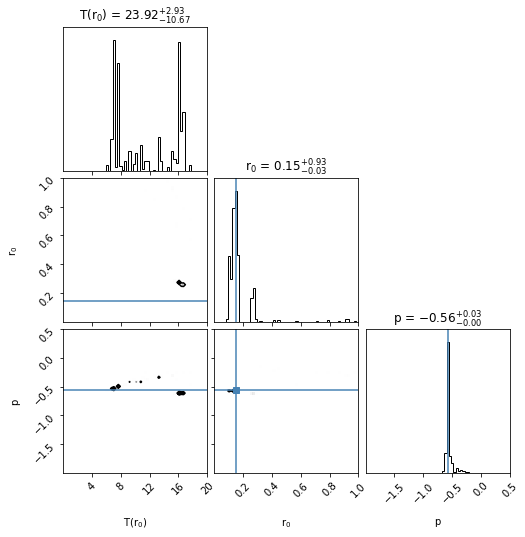

In [4]:
# Data setup
path     = '../../cuts_profiles/'
filename = 'IRS63_b6_pa147.91_major.txt'

# model setup
init_parms   = [20.0, 0.2, -0.75]
model_func   = powerlaw
lnprior_func = powerlaw_lnprior

# MCMC setup
nwalkers        = 10   # need to be a few times larger than the number of free-parameters
nsteps          = 50
n_processor     = 1
step_to_discard = 30

# Flow Control
if_rerun         = True
if_plotSampler   = True
if_outputSamples = False
if_MakeCorner    = True



##### Fitting process #######################################################################################
print('######## Processing ' + path + filename + '##########')

test = profilefit()

# Obtain the angular resolution in the direction of the slice
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                 )
xrange = [0.5*(test.sigma/2.35), 0.2]

# re-load data
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                  ifBrightness=True, xrange = xrange
                 )

# initialize MCMC fittings
test.initialize_mcmc(
                     model_func, lnprior_func, 
                     nwalkers     = nwalkers, 
                     init_parms   = init_parms,  # initial model parameters
                     backend_name = 'single_power_law.h5',
                     rerun = if_rerun
                    )

##### Initialize MCMC #######################################################################################
ncpu = cpu_count()
print("You have {0} CPUs".format(ncpu))

if (n_processor < ncpu):
    # Setup multi-processor
    pool = Pool(processes = n_processor)
        
    # Construct emcee sampler
    sampler = emcee.EnsembleSampler(
                                    test.nwalkers,     # number of walkers
                                    len( test.parms ), # number of free-parameters
                                    test.lnprob,       # function to evaluate log probability
                                    args    = test.args,
                                    backend = test.backend,
                                    # pool = pool        # Multi-processor
                                   )

if (n_processor < ncpu):
    
##### Runnning MCMC ########################################################################################
    print (  '########### Starting running MCMC ###########', time.asctime( time.localtime(time.time()) ) )
    sampler.run_mcmc( test.initial_pos, nsteps, progress=True)
    print (  '########### Finished running MCMC ###########',  time.asctime( time.localtime(time.time()) ) )

    
##### Summarize the results ################################################################################
if (n_processor < ncpu):

    test.summarize_mcmc(sampler, step_to_discard=step_to_discard)
    
    for i in range(0, len(test.parms)):
        s_string = 'parameter ' + str(i) + ': '
        s_string += str( format(test.parms[i], '.2g')      )  + r'+'
        s_string += str(  format(test.parms_u[i] - test.parms[i], '.2g')  )  + r'-'
        s_string += str(  format(test.parms[i] - test.parms_l[i], '.2g')  )
        print(s_string)
    
    # Plot the variation of sampler values as steps
    if if_plotSampler == True:
        test.plot_sampler(sampler, 
                          labels = ['T(r$_{0}$)','r$_{0}$','p'],
                          plot_range = [
                                        (0, 20.0),
                                        (0, 1.0),
                                        (-2.0,0.5)
                                       ]
                         )
    
    # Plot the data and the fitted profile
    label_string = 'p-index  :  ' + str( format(test.parms[2], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[2] - test.parms[2], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[2] - test.parms_l[2], '.2g')  ) + r'}' \
                              + r'$'    
    test.plot_profile(
                  # xscale='log', yscale='log',
                  label = label_string, label_fontsize=16, 
                  x_label='Offset [arcsec]', y_label='Intensity [K]',
                  x_label_fontsize=16, y_label_fontsize=16,
                  tick_fontsize=16,
                 )
    
    # Output all samplers to a ASCII file
    if if_outputSamples == True:
        test.output_samples()
    
    # Making corner plot (extremely time consuming)
    if if_MakeCorner == True:
        test.make_corner(
                         plot_contours = True,
                         labels = ['T(r$_{0}$)','r$_{0}$','p'],
                         plot_range = [
                                       (0, 20.0),
                                       (0, 1.0),
                                       (-2.0,0.5)
                                      ]
                        )


######## Processing ../../cuts_profiles/IRS63_b6_pa147.91_major.txt##########
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
######## Processing ../../cuts_profiles/IRS63_b6_pa147.91_major.txt##########
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
You have 8 CPUs
########### Starting running MCMC ########### Sun Aug 28 20:06:49 2022


100%|█████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.90it/s]


########### Finished running MCMC ########### Sun Aug 28 20:06:57 2022
parameter 0: 13+2.8-0.74
parameter 1: 0.33+0.017-0.051
parameter 2: -0.67+0.058-0.015
parameter 3: -3.7+0.82-0.25


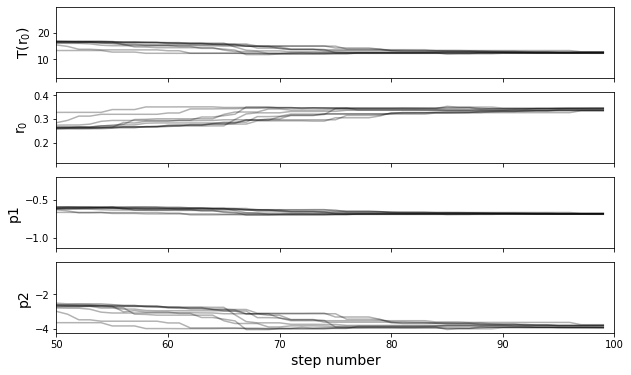

<Figure size 432x288 with 0 Axes>

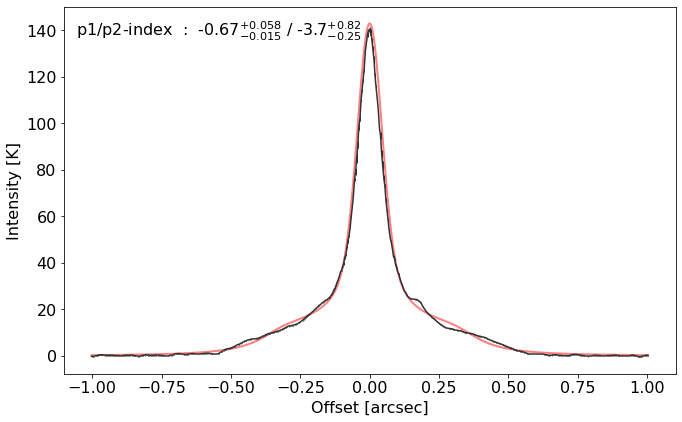

Start making corner plotSun Aug 28 20:06:57 2022
Finished making corner plotSun Aug 28 20:06:59 2022


<Figure size 432x288 with 0 Axes>

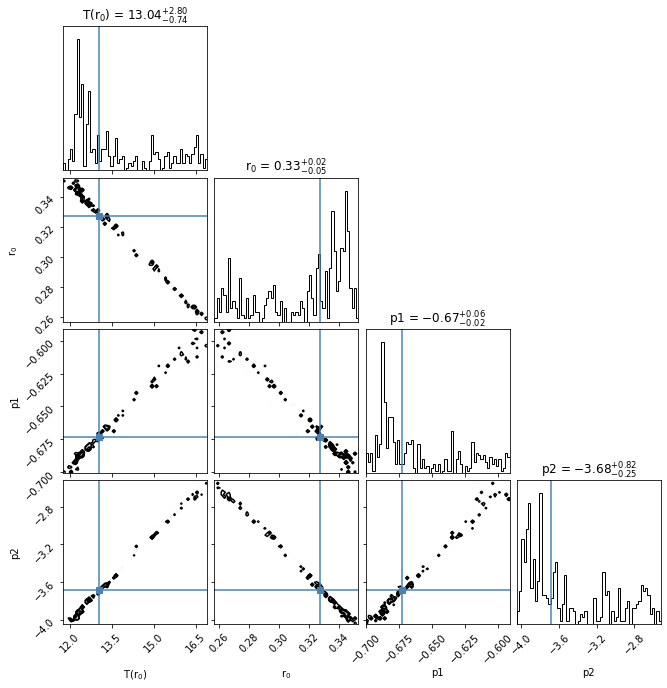

In [5]:
# Data setup
path     = '../../cuts_profiles/'
filename = 'IRS63_b6_pa147.91_major.txt'

# model setup
init_parms   = [20.0, 0.2, -0.75, -2.0]
parms_range  = [
                (0, 20.0),
                (0, 1.0),
                (-1.5,-0.5),
                (-1.5,-0.5)     
               ] 
parms_range  = []

model_func   = brokenpowerlaw
lnprior_func = brokenpowerlaw_lnprior

# MCMC setup
nwalkers        = 10   # need to be a few times larger than the number of free-parameters
nsteps          = 100
n_processor     = 1
step_to_discard = 50

# Flow Control
if_rerun         = False
if_plotSampler   = True
if_outputSamples = False
if_MakeCorner    = True



##### Fitting process #######################################################################################
print('######## Processing ' + path + filename + '##########')

test = profilefit()

# Obtain the angular resolution in the direction of the slice
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                 )
xrange = [0.5*(test.sigma/2.35), 1e10]

# re-load data
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                  ifBrightness=True, xrange = xrange
                 )

##### Fitting process #######################################################################################
print('######## Processing ' + path + filename + '##########')

test = profilefit()

# Obtain the angular resolution in the direction of the slice
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                 )
xrange = [0.5*(test.sigma/2.35), 1e10]

# re-load data
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                  ifBrightness=True, xrange = xrange
                 )

# initialize MCMC fittings
test.initialize_mcmc(
                     model_func, lnprior_func, 
                     nwalkers     = nwalkers, 
                     init_parms   = init_parms,  # initial model parameters
                     backend_name = 'broekn_power_law.h5',
                     rerun = if_rerun
                    )

##### Initialize MCMC #######################################################################################
ncpu = cpu_count()
print("You have {0} CPUs".format(ncpu))

if (n_processor < ncpu):
    # Setup multi-processor
    pool = Pool(processes = n_processor)
        
    # Construct emcee sampler
    sampler = emcee.EnsembleSampler(
                                    test.nwalkers,     # number of walkers
                                    len( test.parms ), # number of free-parameters
                                    test.lnprob,       # function to evaluate log probability
                                    args    = test.args,
                                    backend = test.backend,
                                    # pool = pool        # Multi-processor
                                   )

if (n_processor < ncpu):
    
##### Runnning MCMC ########################################################################################
    print (  '########### Starting running MCMC ###########', time.asctime( time.localtime(time.time()) ) )
    sampler.run_mcmc( test.initial_pos, nsteps, progress=True)
    print (  '########### Finished running MCMC ###########',  time.asctime( time.localtime(time.time()) ) )

    
##### Summarize the results ################################################################################
if (n_processor < ncpu):

    test.summarize_mcmc(sampler, step_to_discard=step_to_discard)

    for i in range(0, len(test.parms)):
        s_string = 'parameter ' + str(i) + ': '
        s_string += str( format(test.parms[i], '.2g')      )  + r'+'
        s_string += str(  format(test.parms_u[i] - test.parms[i], '.2g')  )  + r'-'
        s_string += str(  format(test.parms[i] - test.parms_l[i], '.2g')  )
        print(s_string)
    
    # Plot the variation of sampler values as steps
    if if_plotSampler == True:
        test.plot_sampler(sampler, 
                          labels = ['T(r$_{0}$)','r$_{0}$','p1','p2'],
                          plot_range = parms_range 
                         )
    
    # Plot the data and the fitted profile
    label_string = 'p1/p2-index  :  ' + str( format(test.parms[2], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[2] - test.parms[2], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[2] - test.parms_l[2], '.2g')  ) + r'}' \
                              + r'$' + ' / '
    label_string += str( format(test.parms[3], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[3] - test.parms[3], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[3] - test.parms_l[3], '.2g')  ) + r'}' \
                              + r'$'
    test.plot_profile(
                  # xscale='log', yscale='log',
                  label = label_string, label_fontsize=16, 
                  x_label='Offset [arcsec]', y_label='Intensity [K]',
                  x_label_fontsize=16, y_label_fontsize=16,
                  tick_fontsize=16,
                 )
    
    # Output all samplers to a ASCII file
    if if_outputSamples == True:
        test.output_samples()
    
    # Making corner plot (extremely time consuming)
    if if_MakeCorner == True:
        test.make_corner(
                         plot_contours = True,
                         labels = ['T(r$_{0}$)','r$_{0}$','p1','p2'],
                         plot_range = parms_range 
                        )


######## Processing ../../cuts_profiles/IRS63_b6_pa147.91_major.txt##########
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
You have 8 CPUs
########### Starting running MCMC ########### Sun Aug 28 20:07:02 2022


100%|█████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.30it/s]


########### Finished running MCMC ########### Sun Aug 28 20:07:13 2022
parameter 0: 22+0.11-0.11
parameter 1: 0.18+0.0011-0.00099
parameter 2: 0.5+0.0014-0.00077
parameter 3: -0.54+0.0024-0.0023
parameter 4: -1.3+0.0054-0.0053
parameter 5: -3.1+0.025-0.027


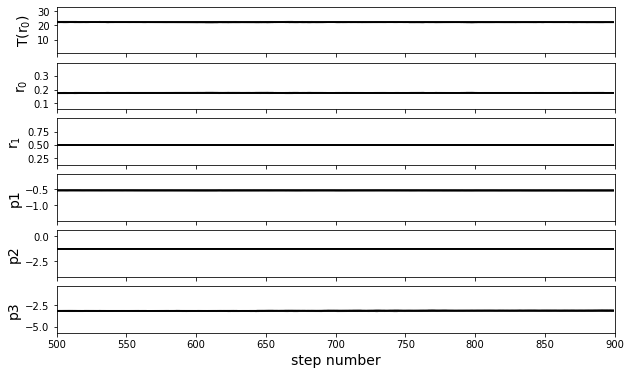

<Figure size 432x288 with 0 Axes>

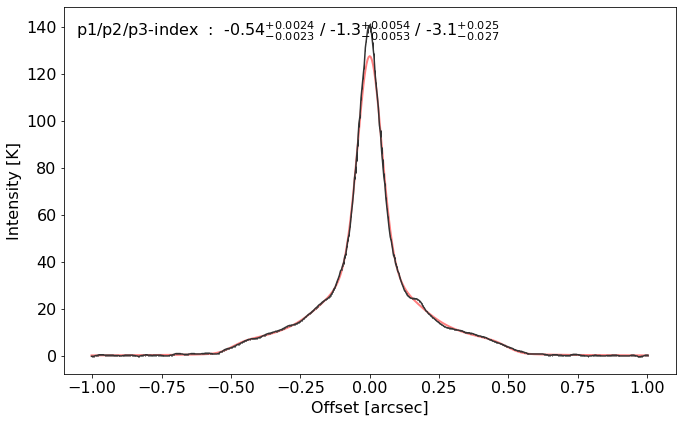

<Figure size 432x288 with 0 Axes>

In [6]:
# Data setup
path     = '../../cuts_profiles/'
filename = 'IRS63_b6_pa147.91_major.txt'

# model setup
init_parms   = [20.0, 0.2, 0.5, -0.75, -2.0, -3.0]
parms_range  = [
                (0, 20.0),
                (0, 0.25),
                (0.25, 0.5),
                (-1.5,-0.5),
                (-1.5,-0.5),
                (-1.5,-0.5)
               ] 
parms_range = []

model_func   = tripowerlaw
lnprior_func = tripowerlaw_lnprior

# MCMC setup
nwalkers        = 15   # need to be a few times larger than the number of free-parameters
nsteps          = 100
n_processor     = 1
step_to_discard = 500

# Flow Control
if_rerun         = True
if_plotSampler   = True
if_outputSamples = False
if_MakeCorner    = False



##### Fitting process #######################################################################################
print('######## Processing ' + path + filename + '##########')

test = profilefit()

# Obtain the angular resolution in the direction of the slice
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                 )
xrange = [0.5*(test.sigma/2.35), 1e10]

# re-load data
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                  ifBrightness=True, xrange = xrange
                 )

# initialize MCMC fittings
test.initialize_mcmc(
                     model_func, lnprior_func, 
                     nwalkers     = nwalkers, 
                     init_parms   = init_parms,  # initial model parameters
                     backend_name = 'tripower_law.h5',
                     rerun = if_rerun
                    )

##### Initialize MCMC #######################################################################################
ncpu = cpu_count()
print("You have {0} CPUs".format(ncpu))

if (n_processor < ncpu):
    # Setup multi-processor
    pool = Pool(processes = n_processor)
        
    # Construct emcee sampler
    sampler = emcee.EnsembleSampler(
                                    test.nwalkers,     # number of walkers
                                    len( test.parms ), # number of free-parameters
                                    test.lnprob,       # function to evaluate log probability
                                    args    = test.args,
                                    backend = test.backend,
                                    # pool = pool        # Multi-processor
                                   )

if (n_processor < ncpu):
    
##### Runnning MCMC ########################################################################################
    print (  '########### Starting running MCMC ###########', time.asctime( time.localtime(time.time()) ) )
    sampler.run_mcmc( test.initial_pos, nsteps, progress=True)
    print (  '########### Finished running MCMC ###########',  time.asctime( time.localtime(time.time()) ) )

    
##### Summarize the results ################################################################################
if (n_processor < ncpu):

    test.summarize_mcmc(sampler, step_to_discard=step_to_discard)
    
    for i in range(0, len(test.parms)):
        s_string = 'parameter ' + str(i) + ': '
        s_string += str( format(test.parms[i], '.2g')      )  + r'+'
        s_string += str(  format(test.parms_u[i] - test.parms[i], '.2g')  )  + r'-'
        s_string += str(  format(test.parms[i] - test.parms_l[i], '.2g')  )
        print(s_string)
    
    # Plot the variation of sampler values as steps
    if if_plotSampler == True:
        test.plot_sampler(sampler, 
                          labels = ['T(r$_{0}$)','r$_{0}$', 'r$_{1}$','p1','p2','p3'],
                          plot_range = parms_range 
                         )
    
    # Plot the data and the fitted profile
    label_string = 'p1/p2/p3-index  :  ' + str( format(test.parms[3], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[3] - test.parms[3], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[3] - test.parms_l[3], '.2g')  ) + r'}' \
                              + r'$' + ' / '
    label_string += str( format(test.parms[4], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[4] - test.parms[4], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[4] - test.parms_l[4], '.2g')  ) + r'}' \
                              + r'$' + ' / '
    label_string += str( format(test.parms[5], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[5] - test.parms[5], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[5] - test.parms_l[5], '.2g')  ) + r'}' \
                              + r'$'  
    test.plot_profile(
                  # xscale='log', yscale='log',
                  label = label_string, label_fontsize=16, 
                  x_label='Offset [arcsec]', y_label='Intensity [K]',
                  x_label_fontsize=16, y_label_fontsize=16,
                  tick_fontsize=16,
                 )
    
    # Output all samplers to a ASCII file
    if if_outputSamples == True:
        test.output_samples()
    
    # Making corner plot (extremely time consuming)
    if if_MakeCorner == True:
        test.make_corner(
                         plot_contours = False,
                         labels = ['T(r$_{0}$)','r$_{0}$', 'r$_{1}$','p1','p2','p3'],
                         plot_range = parms_range 
                        )
